In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import sklearn
print('sklearn version: ', sklearn.__version__)

import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import warnings
warnings.filterwarnings('ignore')

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import random

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve



python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
pandas version:  0.24.2
numpy version:  1.16.4
sklearn version:  0.21.2


Using TensorFlow backend.


keras version:  2.2.4
keras backend:  tensorflow
tensorflow version:  1.14.0


In [2]:
# load data
import pickle
file = open('experiment1_data', 'rb')
X_train, y_train, X_test, y_test = pickle.load(file)
file.close()

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5301, 100)
(5301,)
(2283, 100)
(2283,)


### RNN

In [31]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM, GRU, Dense, Dropout, Masking, TimeDistributed
from numpy.random import seed
from tensorflow import set_random_seed
from copy import deepcopy
from keras.preprocessing.sequence import pad_sequences

In [32]:
def add_previous_outcome(X, Y):
    X = X.copy()
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    return X

In [33]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [34]:
X_train_use = add_previous_outcome(X_train_use, y_train)
X_test_use = add_previous_outcome(X_test_use, y_test)
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [35]:
# Deprecated
# generate 3D tensor
def generate_nested_list_old_old(X, Y):
    X = X.copy()
    Y = Y.copy()
    x_list, y_list = [], [] 
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

In [36]:
# gererate 3D tensor used for padding & masking
# shape: (num_of_paitent, various, num_of_features)
def generate_nested_list_old(X, Y):
    x_list, y_list = [], [] 
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

In [37]:
# generate 3D tensor used for online learning
# shape: (num_of_records, various, num_of_features)
def generate_nested_list(X, Y):
    x_list, y_list = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        x_array = df.drop('patient-id', axis=1).values
        y_array = Y[df.index].values
        x_cache = []
        for x, y in zip(x_array, y_array):
            x_cache.append(x)
            x_list.append(x_cache.copy())
            y_list.append(y)
    return x_list, y_list

In [96]:
X_train_list, y_train_list = generate_nested_list_old(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list_old(X_test_transformed, y_test)

In [39]:
def mygenerator(x_list, y_list=None):
    while True:
        for idx, x in enumerate(x_list):
            t_yield = np.array([x])
            if(y_list is not None):
                t_yield = (t_yield, np.array([y_list[idx]]))
            yield t_yield

In [40]:
g = mygenerator(X_train_list, y_train_list)
next(g)

(array([[[0.00636943, 0.00634249, 0.        , 0.        , 0.55813953,
          1.        , 1.        , 0.        , 0.        , 0.        ,
          1.        , 0.        , 0.        , 1.        , 0.        ,
          0.        , 0.        , 1.        , 1.        , 0.        ,
          0.        , 0.        , 1.        , 0.        , 0.        ,
          0.        , 1.        , 0.        , 0.375     , 0.375     ,
          0.        , 1.        , 0.        , 1.        , 0.60714286,
          0.23529412, 0.        , 0.02345786, 0.02810078, 0.        ,
          0.        , 0.41421356, 1.        , 0.76536686, 0.76536686,
          0.99536331, 0.42523495, 0.99590936, 0.42395451, 0.99281649,
          0.43114763, 0.        , 0.        , 0.        , 0.        ,
          1.        , 0.        , 0.        , 0.        , 1.        ,
          0.        , 1.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        

In [41]:
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
    plt.figure()
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if('val_loss' in history.history):
        val_loss = history.history['val_loss']
        plt.plot(val_loss)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [42]:
def fit_model(model, epoch, X_train, y_train, generator=None, batch_size=None, validation_split=None, verbose=0):
    if(generator is not None):
        if(validation_split is not None):
            train_size = int(len(X_train) * (1 - validation_split))
            X_train_ = X_train[:train_size]
            y_train_ = y_train[:train_size]
            X_valid = X_train[train_size:]
            y_valid = y_train[train_size:]
            history = model.fit_generator(generator(X_train_, y_train_), validation_data=generator(X_valid, y_valid), 
                                          steps_per_epoch=len(X_train_), validation_steps=len(X_valid),
                                          epochs=epoch, verbose=verbose)
        else:
            history = model.fit_generator(generator(X_train, y_train), steps_per_epoch=len(X_train), 
                                          epochs=epoch, verbose=verbose)
    else:
        history = model.fit(X_train, y_train, batch_size=batch_size, validation_split=validation_split, 
                            epochs=epoch, verbose=verbose)
    if(verbose != 0):
        plot_history(history)
    return history

In [43]:
# input type: list
# return type: numpy array
def make_prediction(model, X, generator=None):
    if(generator is not None):
        y_predict = model.predict_generator(generator(X), steps=len(X))
    else:
        y_predict = model.predict(X)
    return np.concatenate(y_predict)

In [44]:
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [45]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)

In [46]:
def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

In [47]:
def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

In [93]:
from keras import regularizers
from keras.optimizers import Adagrad, Adadelta, SGD
def build_model(cell_size, dropout_ratio, n_feature):
    model = Sequential()
    model.add(LSTM(cell_size, input_shape=(None, n_feature), recurrent_dropout=dropout_ratio, dropout=0.5))
#     model.add(CuDNNLSTM(cell_size, input_shape=(None, n_feature)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01), metrics=['binary_accuracy'])
    return model

In [81]:
def _sort_list_by_len(X, y):
    s = sorted(zip(X, y), key=lambda pair: len(pair[0]))
    return [x for (x, y) in s], [y for (x, y) in s]

def generate_batches(X, y, batch_size=32):
    _X, _y = _sort_list_by_len(X, y)
    x_list, y_list = [], []
    prev_idx = 0
    last_len = 1
    def list_append(prev_idx, idx):
        x_list.append(np.array(_X[prev_idx : idx]))
        y_list.append(np.array(_y[prev_idx : idx]))
    for idx, x in enumerate(_X):
        if(len(x) == last_len):
            if(idx - prev_idx == batch_size):
                list_append(prev_idx, idx)
                prev_idx = idx
        else:
            list_append(prev_idx, idx)
            prev_idx = idx
            last_len = len(x)
    list_append(prev_idx, len(_X))
    return x_list, y_list

In [83]:
X_train_batch, y_train_batch = generate_batches(X_train_list, y_train_list)
X_test_batch, y_test_batch = generate_batches(X_test_list, y_test_list)

In [53]:
def mygenerator(x_list, y_list=None):
    while True:
        for idx, x in enumerate(x_list):
            t_yield = x
            if(y_list is not None):
                t_yield = (t_yield, y_list[idx])
            yield t_yield

Epoch 1/200
159/159 [==============================] - 3s 20ms/step - loss: 0.5806 - binary_accuracy: 0.7635 - val_loss: 0.5255 - val_binary_accuracy: 0.7788
Epoch 2/200
159/159 [==============================] - 1s 7ms/step - loss: 0.5038 - binary_accuracy: 0.8209 - val_loss: 0.5411 - val_binary_accuracy: 0.7788
Epoch 3/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4897 - binary_accuracy: 0.8209 - val_loss: 0.5440 - val_binary_accuracy: 0.7788
Epoch 4/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4800 - binary_accuracy: 0.8209 - val_loss: 0.5418 - val_binary_accuracy: 0.7788
Epoch 5/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4742 - binary_accuracy: 0.8209 - val_loss: 0.5378 - val_binary_accuracy: 0.7788
Epoch 6/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4726 - binary_accuracy: 0.8209 - val_loss: 0.5329 - val_binary_accuracy: 0.7788
Epoch 7/200
159/159 [==============================] - 1s

Epoch 53/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4322 - binary_accuracy: 0.8214 - val_loss: 0.4881 - val_binary_accuracy: 0.7913
Epoch 54/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4315 - binary_accuracy: 0.8261 - val_loss: 0.4881 - val_binary_accuracy: 0.7944
Epoch 55/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4329 - binary_accuracy: 0.8229 - val_loss: 0.4877 - val_binary_accuracy: 0.7913
Epoch 56/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4332 - binary_accuracy: 0.8203 - val_loss: 0.4871 - val_binary_accuracy: 0.7882
Epoch 57/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4288 - binary_accuracy: 0.8221 - val_loss: 0.4870 - val_binary_accuracy: 0.7882
Epoch 58/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4264 - binary_accuracy: 0.8254 - val_loss: 0.4871 - val_binary_accuracy: 0.7913
Epoch 59/200
159/159 [==============================

Epoch 105/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4283 - binary_accuracy: 0.8254 - val_loss: 0.4834 - val_binary_accuracy: 0.8037
Epoch 106/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4223 - binary_accuracy: 0.8258 - val_loss: 0.4834 - val_binary_accuracy: 0.8037
Epoch 107/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4252 - binary_accuracy: 0.8234 - val_loss: 0.4841 - val_binary_accuracy: 0.8006
Epoch 108/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4249 - binary_accuracy: 0.8232 - val_loss: 0.4841 - val_binary_accuracy: 0.8037
Epoch 109/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4263 - binary_accuracy: 0.8233 - val_loss: 0.4837 - val_binary_accuracy: 0.8006
Epoch 110/200
159/159 [==============================] - 1s 7ms/step - loss: 0.4242 - binary_accuracy: 0.8247 - val_loss: 0.4836 - val_binary_accuracy: 0.8006
Epoch 111/200
159/159 [=======================

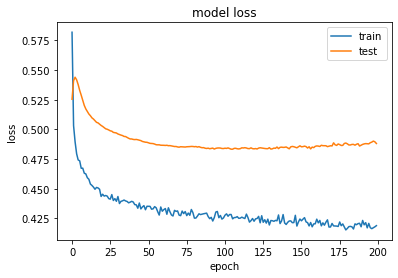

In [94]:
# %%time
# with previous outcome
seed(1)
set_random_seed(2)
n_feature = X_train_batch[0].shape[2]
model = build_model(32, 0.5, n_feature)
history = fit_model(model, 200, X_train_batch, y_train_batch, generator=mygenerator, validation_split=0.1, verbose=1)

In [85]:
y_predict = make_prediction(model, X_test_batch, generator=mygenerator)
y_predict.shape

(2283,)

In [95]:
y_predict = make_prediction(model, X_test_batch, generator=mygenerator)
y_true = np.concatenate(y_test_batch)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

auroc:  0.721183446726172
f1:  0.4568527918781725
threshold:  0.17882961
precision:  0.4076086956521739
recall:  0.5196304849884527
accuracy:  0.7656592203241349
specificity:  0.8232432432432433


In [ ]:
def pad_data(X, maxlen):
    return pad_sequences(X, maxlen=maxlen, dtype='float64', padding='post')

def pad_all(X_train, y_train, X_test, y_test, maxlen):
    return pad_data(X_train, maxlen), pad_data(y_train, maxlen), pad_data(X_test, maxlen), pad_data(y_test, maxlen)

In [ ]:
def truncate_prediction(y_, y_len):
    y_concat = []
    for i, y in enumerate(y_):
        y_concat.append(np.concatenate(y[:y_len[i], :]))
    y_concat = np.concatenate(y_concat)
    return y_concat

In [ ]:
from sklearn.model_selection import GroupKFold
def kfold_validation_old(unit, ratio, epoch, X, y, groupby, k=5, verbose=0):
    auroc_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, 1, X_train[0][0].shape[0])
        if (verbose == 0):
            fit_model(model, epoch, X_train, y_train)
        else:
            fit_model(model, epoch, X_train, y_train, X_valid, y_valid, verbose)
        y_predict = model.predict_generator(mygenerator(X_valid), steps=len(X_valid))
        y_predict = np.concatenate(y_predict)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
    return auroc_list 

In [ ]:
X_train_pad, y_train_pad, X_test_pad, y_test_pad = pad_all(X_train_list, y_train_list, X_test_list, y_test_list, max_timestamps)
y_train_pad = y_train_pad.reshape((2193, 19, 1))

In [ ]:
X_train_pad2, y_train_pad2, X_test_pad2, y_test_pad2 = pad_all(X_train_list2, y_train_list2, X_test_list2, y_test_list2, max_timestamps)
y_train_pad2 = y_train_pad2.reshape((2193, 19, 1))

In [ ]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, k=5, verbose=0, max_timestamps=20, n_features=100):
    auroc_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        X_train_pad, y_train_pad, X_valid_pad, y_valid_pad = pad_all(X_train, y_train, X_valid, y_valid, max_timestamps)
        y_train_pad = y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, max_timestamps, n_features)
        fit_model(model, epoch, X_train_pad, y_train_pad, verbose=verbose)
        y_valid_len = [len(y) for y in y_valid]
        y_predict = model.predict(X_valid_pad)
        y_predict = truncate_prediction(y_predict, y_valid_len)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
    return auroc_list 

In [ ]:
%%time
# with previous outcome
# add outcome before scaling
seed(1)
set_random_seed(2)
model = build_model(32, 0.5, max_timestamps, n_features)
fit_model(model, 175, X_train_pad, y_train_pad, verbose=1)
y_predict = model.predict(X_test_pad)
y_test_len = [len(y) for y in y_test_list]
y_predict = truncate_prediction(y_predict, y_test_len)
y_true = np.concatenate(y_test_list)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

In [ ]:
%%time
# with previous outcome
# scale before add
seed(1)
set_random_seed(2)
model = build_model(32, 0.5, max_timestamps, n_features2)
fit_model(model, 175, X_train_pad2, y_train_pad2, verbose=1)
y_predict = model.predict(X_test_pad2)
y_test_len = [len(y) for y in y_test_list2]
y_predict = truncate_prediction(y_predict, y_test_len)
y_true = np.concatenate(y_test_list2)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

In [ ]:
# training set performance
y_predict_train = model.predict(X_train_pad)
y_train_len = [len(y) for y in y_train_list]
y_predict_train = truncate_prediction(y_predict_train, y_train_len)
y_true_train = np.concatenate(y_train_list)
print('auroc: ', auroc(y_predict_train, y_true_train))
f1, th = find_best_f1(y_predict_train, y_true_train)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict_train, y_true_train, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

In [ ]:
%%time
# K-Fold Cross Validation
result = []
pdic = [(32, [], [0.5])]
for unit, epoch_list, ratio_list in pdic:
    for epoch in epoch_list:
        for ratio in ratio_list:
            auroc_list = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', \
                                          verbose=1, max_timestamps=max_timestamps, n_features=n_features)
            result.append((unit, epoch, auroc_list))
            print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

In [ ]:
for unit, epoch, auroc_list in result:
    print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 32	epoch: 5	auroc_mean: 0.671844	auroc_std: 0.011108
unit: 32	epoch: 50	auroc_mean: 0.689895	auroc_std: 0.011584
unit: 32	epoch: 100	auroc_mean: 0.693467	auroc_std: 0.012354
unit: 32	epoch: 125	auroc_mean: 0.695942	auroc_std: 0.012456
unit: 32	epoch: 150	auroc_mean: 0.697040	auroc_std: 0.012438
unit: 32	epoch: 175	auroc_mean: 0.697905	auroc_std: 0.012803
unit: 32	epoch: 200	auroc_mean: 0.698378	auroc_std: 0.012308

unit: 24	epoch: 50	auroc_mean: 0.688865	auroc_std: 0.009856

In [ ]:
%%time
seed(1)
set_random_seed(2)
auroc_list = []
precision_list = []
recall_list = []
accuracy_list = []
specificity_list = []
f1_list = []
th_list = []
for i in range(0,1):
    model = build_model(32, 0.5, 1, X_train_list[0][0].shape[0])
    history = fit_model(model, 180, X_train_list, y_train_list, X_test_list, y_test_list, verbose=1)
    y_predict = model.predict_generator(mygenerator(X_test_list), steps=len(X_test_list))
    y_predict = np.concatenate(y_predict)
    y_true = np.concatenate(y_test_list)
    auroc_list.append(auroc(y_predict, y_true))
    f1, th = find_best_f1(y_predict, y_true)
    f1_list.append(f1)
    th_list.append(th)
    precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)
print('avg auroc: ', np.mean(auroc_list))
print('avg precision: ', np.mean(precision_list))
print('avg recall: ', np.mean(recall_list))
print('avg accuracy: ', np.mean(accuracy_list))
print('avg specificity: ', np.mean(specificity_list))
print('avg f1: ', np.mean(f1_list));
print('auroc: ', auroc_list)
print('precision: ', precision_list)
print('recall: ', recall_list)
print('accuracy: ', accuracy_list)
print('specificity: ', specificity_list)
print('f1: ', f1_list);
print('threshold: ', th_list)

In [ ]:
y_predict_t = model.predict_generator(mygenerator(X_train_list), steps=len(X_train_list))
y_predict_t = np.concatenate(y_predict_t)
y_true_t = np.concatenate(y_train_list)

f1_t, th_t = find_best_f1(y_predict_t, y_true_t)
precision_t, recall_t, accuracy_t, specificity_t = other_metrics(y_predict_t, y_true_t, th_t)

print('auroc: ', auroc(y_predict_t, y_true_t))
print('precision: ', precision_t)
print('recall: ', recall_t)
print('accuracy: ', accuracy_t)
print('specificity: ', specificity_t)
print('f1: ', f1_t);
print('threshold: ', th_t)

In [ ]:
# from sklearn.calibration import calibration_curve
# # fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_predict, n_bins=10)
# fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_predict, normalize=True, n_bins=10)
# with open("exp_1_cal.csv", "w") as writeFile:
#     writer  = csv.writer(writeFile)
#     writer.writerows([fraction_of_positives, mean_predicted_value])

# plt.figure()
# plt.plot(mean_predicted_value, fraction_of_positives, 's-')
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.show()

In [ ]:
# import csv 
# fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)
# plot_roc_curve(fpr, tpr)
# with open("exp_1.csv", "w") as writeFile:
#     writer  = csv.writer(writeFile)
#     writer.writerows([fpr, tpr, [recall, 1-specificity]])

In [ ]:
%%time
seed(1)
set_random_seed(2)
auroc_list = []
precision_list = []
recall_list = []
accuracy_list = []
specificity_list = []
f1_list = []
th_list = []
for i in range(0,5):
    model = build_model(32, 0.5, 1, X_train_list[0][0].shape[0])
    history = fit_model(model, 180, X_train_list, y_train_list, X_test_list, y_test_list, verbose=1)
    y_predict = model.predict_generator(mygenerator(X_test_list), steps=len(X_test_list))
    y_predict = np.concatenate(y_predict)
    y_true = np.concatenate(y_test_list)
    auroc_list.append(auroc(y_predict, y_true))
    f1, th = find_best_f1(y_predict, y_true)
    f1_list.append(f1)
    th_list.append(th)
    precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)
print('avg auroc: ', np.mean(auroc_list))
print('avg precision: ', np.mean(precision_list))
print('avg recall: ', np.mean(recall_list))
print('avg accuracy: ', np.mean(accuracy_list))
print('avg specificity: ', np.mean(specificity_list))
print('avg f1: ', np.mean(f1_list));
print('auroc: ', auroc_list)
print('precision: ', precision_list)
print('recall: ', recall_list)
print('accuracy: ', accuracy_list)
print('specificity: ', specificity_list)
print('f1: ', f1_list);
print('threshold: ', th_list)

In [ ]:
%%time
# K-Fold Cross Validation
ratio = 0.1
result = []
pdic = [(32, [225], [0.5])]
for unit, epoch_list, ratio_list in pdic:
    for epoch in epoch_list:
        for ratio in ratio_list:
            auroc_list = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', verbose=1)
            result.append((unit, epoch, auroc_list))
            print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

In [ ]:
for unit, epoch, auroc_list in result:
    print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 32	epoch: 150	auroc_mean: 0.716831	auroc_std: 0.013252
unit: 32	epoch: 175	auroc_mean: 0.717295	auroc_std: 0.013509
unit: 32	epoch: 200	auroc_mean: 0.717797	auroc_std: 0.013301